"""
MIT License

Copyright (c) 2021 porteratzo

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

Introduction

This document serves as a tutorial for using the treetool tool, a software for detecting trees in a point cloud and measuring their diameter at breast height (1.3 m). This document seeks to demonstrate the operation of treetool, whether used as a stand-alone application or integrated as a package with other applications.

Usage guide

Below we describe our demo notebook contained in the QuickDemo.ipynb file. This notebook illustrates the operation and use of our software, from loading a point cloud, viewing it, processing it with our algorithm and saving the results.


Load the libraries that we will use and had previously installed

In [1]:
import os

os.environ["OPEN3D_DISABLE_WEB_VISUALIZER"] = "true"
import open3d as o3d
import numpy as np
import treetool.seg_tree as seg_tree
import treetool.utils as utils
import treetool.tree_tool as tree_tool
import pandas as pd
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from porteratzo3D.visualization.open3d_vis import open3dpaint
from porteratzo3D.visualization.open3d_pointset_class import O3dPointSetClass

Load the point cloud from a .pcd using pclpy, we use our function seg_tree which contains many helper functions such as voxelize to down sample our point cloud and visualize using our Visualization function built on open3d. 


In [2]:
file_directory = r"data/downsampledlesscloudEURO3.pcd"
pc_original = o3d.io.read_point_cloud(file_directory)
pc_downsampled = seg_tree.voxelize(pc_original, 0.06)
open3dpaint(np.asarray(pc_downsampled.points), pointsize=2)

FEngine (64 bits) created at 0x64d490eaea90 (threading is enabled)
FEngine resolved backend: OpenGL


In [3]:
pc_original, pc_downsampled

(PointCloud with 7343999 points., PointCloud with 3301660 points.)

Tree tool is our main class that contains the routines for tree detection and DBH extraction

In [4]:
My_treetool = tree_tool.treetool(pc_downsampled)

Our tree top object has a series of functions that are performed to obtain DBH and tree detection.

In [ ]:
My_treetool.step_1_remove_floor()

# Obtained attributes:
# non_ground_cloud: All points in the point cloud that don't belong to the ground
# ground_cloud: All points in the point cloud that belong to the ground
open3dpaint(
    [np.asarray(My_treetool.non_ground_cloud.points), np.asarray(My_treetool.ground_cloud.points)],
    voxel_size=0.1,
)

imDefLkup.c,419: The application disposed a key event with 444 serial.


Set Algorithm Parameters

Run main process

In [24]:
# Get point normals for filtering

# Obtained attributes:
# non_filtered_points: Same as non_ground_cloud
# non_filtered_normals: Normals of points in non_filtered_points
# filtered_points: Points that pass the normal filter
# filtered_normals: Normals of points that pass the normal filter
from tictoc import timer

My_treetool.step_2_normal_filtering(
    verticality_threshold=0.08, curvature_threshold=0.08, search_radius=0.08
)
open3dpaint(
    [
        np.asarray(My_treetool.non_ground_cloud.points),
        np.asarray(My_treetool.filtered_points),
    ],
    voxel_size=0.1
)


1 1.7964000107895117e-05
1 0.01770327200028987
2 4.818900015379768e-05
3 2.5470104289997835
4 2.448223266000241
5 6.0723999922629446e-05
6 2.296078980999482
7 0.02760200300053839
2 0.0003022959999725572
3 0.0573318790002304
4 0.011528658000315772
5 0.026435220000166737


In [20]:
curv_bool = My_treetool.curvature < 0.5
ver_bool = My_treetool.verticality < 0.5

show_points_curv = np.asarray(My_treetool.non_filtered_points)[curv_bool,:]
show_colors_curv = My_treetool.curvature[curv_bool]

show_points_ver = np.asarray(My_treetool.non_filtered_points)[ver_bool.ravel(),:]
show_colors_ver = My_treetool.verticality[ver_bool]


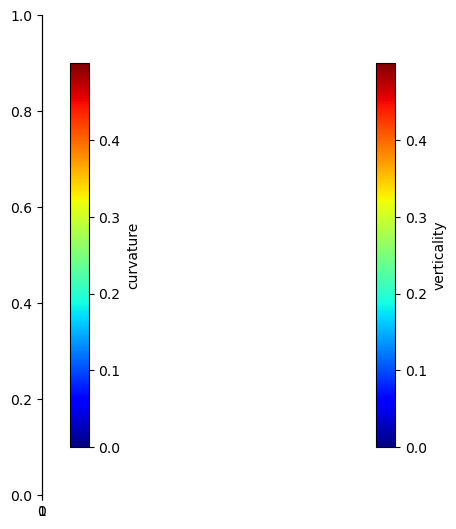

In [22]:
filter_points = np.asarray(My_treetool.filtered_points)
open3dpaint(
    [
        O3dPointSetClass(
            show_points_curv,
            show_colors_curv,
            name="curvature",show_color_bars=True
        ),
        O3dPointSetClass(
            show_points_ver,
            show_colors_ver,
            name="verticality",show_color_bars=True
        ),
    ],
    voxel_size=0.1,
    pointsize=2,show_color_bars=True
)

In [25]:
My_treetool.step_3_dbscan_clustering(eps=0.4, min_cluster_size=20)

# Obtained attributes:
# cluster_list: List of all clusters obtained with Euclidean Clustering

open3dpaint(My_treetool.cluster_list, voxel_size=0.1)

In [26]:
# Group stem segments
My_treetool.step_4_group_stems(max_distance=0.4)

# Obtained attributes:
# complete_Stems: List of all complete stems obtained by joining clusters belonging to the same tree

open3dpaint(My_treetool.complete_Stems, voxel_size=0.1)

In [27]:
My_treetool.step_5_get_ground_level_trees(lowstems_height=5, cutstems_height=5)

# Obtained attributes:
# low_stems: List of all stems truncated to the specified height

open3dpaint(My_treetool.low_stems, voxel_size=0.1)

In [28]:
My_treetool.step_6_get_cylinder_tree_models(search_radius=0.1)

# Obtained attributes:
# finalstems: List of Dictionaries with two keys 'tree' which contains the points used to fit the cylinder model and 'model' which contains the cylinder model parameters
# visualization_cylinders: List of the pointclouds that represent the tree modeled with a cylinder

open3dpaint(
    [i["tree"] for i in My_treetool.finalstems] + My_treetool.visualization_cylinders,
    voxel_size=0.1,
)

In [29]:
My_treetool.step_7_ellipse_fit()

# Obtained attributes:
# Three new keys in our finalstems dictionaries:
# final_diameter: Final DBH of every tree
# cylinder_diameter: DBH obtained with cylinder fitting
# ellipse_diameter;DBH obtained with Ellipse fitting

Finally, we save the extracted trees and their DBH

In [ ]:
My_treetool.save_results(save_location="results/myresults.csv")

Load Cloud and visualize

WARNING: Please adjust the path before executing

In [ ]:
file_directory = r"data/downsampledlesscloudEURO3.pcd"
pc_original = o3d.io.read_point_cloud(file_directory)
pc_downsampled = seg_tree.voxelize(pc_original, 0.06)

In [ ]:
My_treetool.point_cloud = tree_tool.set_point_cloud(pc_downsampled)

In [ ]:
My_treetool.full_process(
    verticality_threshold=0.1,
    curvature_threshold=0.1,
    dbscan_eps=0.4,
    min_cluster_size=20,
    group_stems_max_distance=0.4,
    lowstems_height=5,
    cutstems_height=5,
    search_radius=0.1,
)

cloud_match = [i["tree"] for i in My_treetool.finalstems] + [
    i for i in My_treetool.visualization_cylinders
]
open3dpaint(cloud_match + [np.asarray(pc_downsampled.points)], voxel_size=0.1)

WARNING: Please adjust the path before executing

In [ ]:
#####################################################
# Get ground truth
tree_data = pd.read_csv(
    "data/TLS_Benchmarking_Plot_3_LHD.txt", sep="\t", names=["x", "y", "height", "DBH"]
)
Xcor, Ycor, diam = tree_data.iloc[0, [0, 1, 3]]
cylinders_from_GT = [
    utils.makecylinder(model=[Xcor, Ycor, 0, 0, 0, 1, diam / 2], height=10, density=20)
]
TreeDict = [np.array([Xcor, Ycor, diam])]
for i, rows in tree_data.iloc[1:].iterrows():
    Xcor, Ycor, diam = rows.iloc[[0, 1, 3]]
    if not np.any(np.isnan([Xcor, Ycor, diam])):
        cylinders_from_GT.append(
            utils.makecylinder(model=[Xcor, Ycor, 0, 0, 0, 1, diam / 2], height=10, density=10)
        )
        TreeDict.append(np.array([Xcor, Ycor, diam]))
cloud_of_cylinders_from_GT = [p for i in cylinders_from_GT for p in i]

# DataBase
# Found trees
# Hungarian Algorithm assignment
CostMat = np.ones([len(TreeDict), len(My_treetool.visualization_cylinders)])
for X, datatree in enumerate(TreeDict):
    for Y, foundtree in enumerate(My_treetool.finalstems):
        CostMat[X, Y] = np.linalg.norm([datatree[0:2] - foundtree["model"][0:2]])

dataindex, foundindex = linear_sum_assignment(CostMat, maximize=False)

# Get metrics
locationerror = []
correctlocationerror = []
diametererror = []
diametererrorElipse = []
diametererrorComb = []
cloud_match = []
for i, j in zip(dataindex, foundindex):
    locationerror.append(
        np.linalg.norm((My_treetool.finalstems[j]["model"][0:2] - TreeDict[i][0:2]))
    )
    if locationerror[-1] < 0.6:
        if My_treetool.finalstems[j]["cylinder_diameter"] is not None:
            diametererror.append(
                abs(My_treetool.finalstems[j]["cylinder_diameter"] - TreeDict[i][2])
            )
            diametererrorElipse.append(
                abs(My_treetool.finalstems[j]["ellipse_diameter"] - TreeDict[i][2])
            )
            mindi = max(
                My_treetool.finalstems[j]["cylinder_diameter"],
                My_treetool.finalstems[j]["ellipse_diameter"],
            )
            mendi = np.mean(
                [
                    My_treetool.finalstems[j]["cylinder_diameter"],
                    My_treetool.finalstems[j]["ellipse_diameter"],
                ]
            )
            diametererrorComb.append(abs(mindi - TreeDict[i][2]))
            correctlocationerror.append(
                np.linalg.norm((My_treetool.finalstems[j]["model"][0:2] - TreeDict[i][0:2]))
            )
            cloud_match.append(
                np.vstack(
                    [
                        cylinders_from_GT[i],
                        My_treetool.finalstems[j]["tree"],
                        My_treetool.visualization_cylinders[j],
                    ]
                )
            )

In [ ]:
n_ref = len(TreeDict)
n_match = len(diametererror)
n_extr = len(locationerror) - n_match

Completeness = n_match / n_ref
Correctness = n_match / (n_extr + n_match)

In [ ]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
plt.hist(diametererror, 50)
plt.title("Cylinder DBH error")

plt.subplot(1, 3, 2)
plt.hist(diametererrorComb, 50)
plt.title("Final DBH error")

plt.subplot(1, 3, 3)
plt.hist(correctlocationerror, 50)
plt.title("Location error")

print("Total number of trees in Ground Truth: ", n_ref)
print("Total number of trees matched with Ground Truth: ", n_match)
print("Total number of trees extra trees found: ", n_extr)

print("Percentage of matched trees: ", round(Completeness * 100), "%")
print("Percentage of correctly matched trees: ", round(Correctness * 100), "%")

print(
    "Cylinder DBH mean Error: ",
    np.mean(diametererror),
)
print("Ellipse DBH mean Error: ", np.mean(diametererrorElipse))
print("Final DBH mean Error: ", np.mean(diametererrorComb))